In [7]:
import tensorflow as tf
import os
from shutil import copy2
import csv
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt                           

In [8]:
!pip install tensorflow_hub

In [11]:
import tensorflow_hub as hub

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
tf.__version__

'2.4.1'

In [15]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
data_root = ("/content/drive/MyDrive/Dataset")

In [18]:
data_root

'/content/drive/MyDrive/Dataset'

In [19]:
IMAGE_SHAPE = (224,224)

In [20]:
TRAINING_DATA_DIR = str(data_root)

In [21]:
datagen_kwargs = dict(rescale = 1./255, validation_split = .20)

In [23]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

Found 129 images belonging to 6 classes.
Found 523 images belonging to 6 classes.


In [31]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 6))

In [32]:
label_batch[0:20]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [34]:
print(train_generator.shape)

AttributeError: ignored

In [35]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

Black
Blue
Brown
Green
Red
White

In [36]:
IMAGE_SIZE = 224
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [38]:
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit_generator(
    train_generator, 
    epochs=100,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
17/17 [==============================] - 240s 14s/step - loss: 2.0309 - acc: 0.2716 - val_loss: 1.4657 - val_acc: 0.4651
Epoch 2/100
17/17 [==============================] - 27s 2s/step - loss: 1.1308 - acc: 0.5961 - val_loss: 1.1801 - val_acc: 0.5659
Epoch 3/100
17/17 [==============================] - 27s 2s/step - loss: 0.8140 - acc: 0.7290 - val_loss: 1.0562 - val_acc: 0.6434
Epoch 4/100
17/17 [==============================] - 27s 2s/step - loss: 0.6559 - acc: 0.7715 - val_loss: 1.0049 - val_acc: 0.6279
Epoch 5/100
17/17 [==============================] - 28s 2s/step - loss: 0.5574 - acc: 0.8109 - val_loss: 0.9637 - val_acc: 0.6744
Epoch 6/100
17/17 [==============================] - 28s 2s/step - loss: 0.4556 - acc: 0.8356 - val_loss: 0.9511 - val_acc: 0.6589
Epoch 7/100
17/17 [==============================] - 27s 2s/step - loss: 0.3667 - acc: 0.8692 - val_loss: 0.9214 - val_acc: 0.6822
Epoch 8/100
17/17 [==============================] - 27s 2s/step - loss: 0.3579 -

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

4/4 [==============================] - 4s 835ms/step - loss: 0.8332 - acc: 0.7851
Final loss: 0.83
Final accuracy: 78.51%


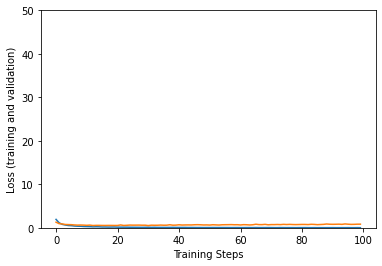

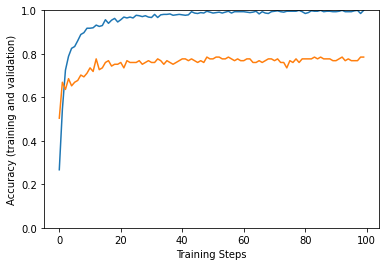

In [ ]:

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Black' 'Blue' 'Brown' 'Green' 'Red' 'White']


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 6)


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

['Black' 'Green' 'White' 'Black' 'White' 'White' 'Brown' 'Blue' 'White'
 'Brown' 'Brown' 'Red' 'Blue' 'White' 'White' 'Brown' 'Black' 'White'
 'White' 'Blue' 'Blue' 'Green' 'Brown' 'Black' 'Brown' 'Black' 'Red'
 'Black' 'Red' 'Brown' 'Black' 'White']


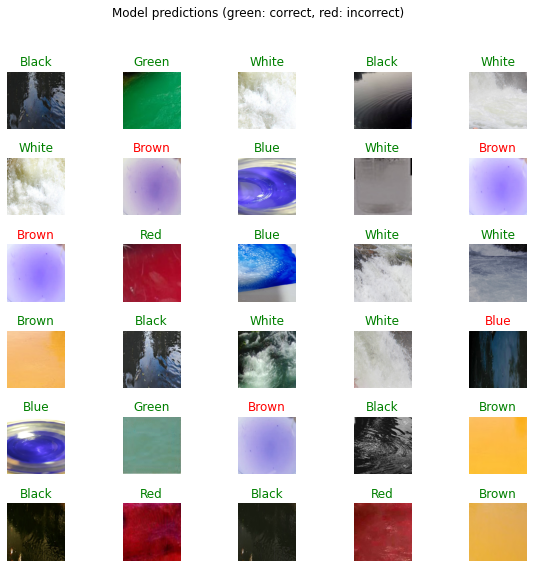

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace = 0.5)
for n in range((len(predicted_labels)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")